In [1]:
# !pip install PySastrawi

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import Sastrawi

In [2]:
#DATASET SOURCE FROM https://github.com/dbrehmer/Knowself/blob/master/data/mypersonality/essays.csv"
#DATASET USED IN THIS NOTEBOOK IS DATASET FROM THE SOURCE THAT HAS BEEN TRANSLATED TO BAHASA INDONESIA USING GOOGLE TRANSLATE

DATASET_URL = "https://raw.githubusercontent.com/lazuardi100/Hexa-Engineer/ML/Dataset/dataset.csv"
df = pd.read_csv(DATASET_URL, sep =',')

df.head()

,#AUTHID,TTEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Nah, sekarang saya baru saja bangun dari tidur...",n,y,y,n,y
1,1997_605191.txt,"Nah, di sini kita pergi dengan arus kesadaran ...",n,n,y,n,n
2,1997_687252.txt,Keyboard terbuka dan tombol untuk mendorong. H...,n,y,n,y,y
3,1997_568848.txt,Aku tidak percaya itu! Ini benar-benar terjadi...,y,n,y,y,n
4,1997_688160.txt,"Nah, di sini aku pergi dengan aliran tua yang ...",y,n,y,n,y


In [3]:
def changeLabel(labels):
  for index, values in enumerate(labels.values):
    if values == 'n':
      labels[index] = 0
    else:
      labels[index] = 1
  return labels

changeLabel(df['cEXT'])
changeLabel(df['cNEU'])
changeLabel(df['cAGR'])
changeLabel(df['cCON'])
changeLabel(df['cOPN'])

0       1
1       0
2       1
3       0
4       1
       ..
2462    0
2463    1
2464    0
2465    1
2466    1
Name: cOPN, Length: 2467, dtype: object

In [4]:
#Text Preprocessing referenced from https://github.com/ksnugroho/basic-text-preprocessing/blob/master/text-preprocessing.ipynb
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def preprocess_text(text):
  #lowercase all character in the text
  text = text.lower()
  #remove punctuation
  text = text.translate(str.maketrans("","",string.punctuation))
  #remove leading and trailing whitespace
  text = text.strip()
  #remove StopWord
  stopword = StopWordRemoverFactory().create_stop_word_remover()
  text = stopword.remove(text)
  #stemming
  stemmer = StemmerFactory().create_stemmer()
  text = stemmer.stem(text)
  return text

df['TTEXT'] = df['TTEXT'].map(preprocess_text)

In [5]:
df = df.sample(frac=1)
train_dataset, val_dataset, test_dataset = np.split(df, [int(.95 * len(df)), int(.975 * len(df))])

In [6]:
train_data = train_dataset['TTEXT']
train_label_ext  = train_dataset['cEXT']
train_label_neu  = train_dataset['cNEU']
train_label_agr  = train_dataset['cAGR']
train_label_con  = train_dataset['cCON']
train_label_opn  = train_dataset['cOPN']

val_data = val_dataset['TTEXT']
val_label_ext  = val_dataset['cEXT']
val_label_neu  = val_dataset['cNEU']
val_label_agr  = val_dataset['cAGR']
val_label_con  = val_dataset['cCON']
val_label_opn  = val_dataset['cOPN']

test_data = test_dataset['TTEXT']
test_label_ext  = test_dataset['cEXT']
test_label_neu  = test_dataset['cNEU']
test_label_agr  = test_dataset['cAGR']
test_label_con  = test_dataset['cCON']
test_label_opn  = test_dataset['cOPN']

In [7]:
#Exploring Data

# import statistics
# word_counts = []
# for data in train_data:
#   word_count = len(data.split())
#   word_counts.append(word_count)
# print("mean: ",statistics.mean(word_counts))
# print("median: ",statistics.median(word_counts))
# print("max: ",max(word_counts))
# print("min: ",min(word_counts))

In [8]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# #Tried to use parameter and model from the NLP Course by Deeplearning.ai
# vocab_size = 10000
# embedding_dim = 16
# max_length = 600
# trunc_type='post'
# padding_type='post'
# oov_tok = "<OOV>"
# training_size = 20000

# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(train_data)

# training_sequences = tokenizer.texts_to_sequences(train_data)
# training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# val_sequences = tokenizer.texts_to_sequences(val_data)
# val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# test_sequences = tokenizer.texts_to_sequences(test_data)
# test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
#Create Data Pipeline

# train_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((training_padded, train_label_ext.values.astype(dtype=np.float32)))
train_dataset_ext = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_ext.values.astype(dtype=np.float32)))
train_dataset_neu = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_neu.values.astype(dtype=np.float32)))
train_dataset_agr = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_agr.values.astype(dtype=np.float32)))
train_dataset_con = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_con.values.astype(dtype=np.float32)))
train_dataset_opn = tf.data.Dataset.from_tensor_slices((train_data.values, train_label_opn.values.astype(dtype=np.float32)))

# val_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((val_padded, val_label_ext.values.astype(dtype=np.float32)))
val_dataset_ext = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_ext.values.astype(dtype=np.float32)))
val_dataset_neu = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_neu.values.astype(dtype=np.float32)))
val_dataset_agr = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_agr.values.astype(dtype=np.float32)))
val_dataset_con = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_con.values.astype(dtype=np.float32)))
val_dataset_opn = tf.data.Dataset.from_tensor_slices((val_data.values, val_label_opn.values.astype(dtype=np.float32)))

# test_dataset_ext_2 = tf.data.Dataset.from_tensor_slices((test_padded, test_label_ext.values.astype(dtype=np.float32)))
test_dataset_ext = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_ext.values.astype(dtype=np.float32)))
test_dataset_neu = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_neu.values.astype(dtype=np.float32)))
test_dataset_agr = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_agr.values.astype(dtype=np.float32)))
test_dataset_con = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_con.values.astype(dtype=np.float32)))
test_dataset_opn = tf.data.Dataset.from_tensor_slices((test_data.values, test_label_opn.values.astype(dtype=np.float32)))

In [31]:
batch_size = 128
num_examples = tf.data.experimental.cardinality(train_dataset_ext).numpy()

# ext_train_batches = train_dataset_ext.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
# ext_val_batches = val_dataset_ext.batch(batch_size).prefetch(1)
# ext_test_batches = test_dataset_ext.batch(batch_size)

# neu_train_batches = train_dataset_neu.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
# neu_val_batches = val_dataset_neu.batch(batch_size).prefetch(1)
# neu_test_batches = test_dataset_neu.batch(batch_size)

# agr_train_batches = train_dataset_agr.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
# agr_val_batches = val_dataset_agr.batch(batch_size).prefetch(1)
# agr_test_batches = test_dataset_agr.batch(batch_size)

# con_train_batches = train_dataset_con.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
# con_val_batches = val_dataset_con.batch(batch_size).prefetch(1)
# con_test_batches = test_dataset_con.batch(batch_size)

opn_train_batches = train_dataset_opn.shuffle(num_examples // 4).batch(batch_size).prefetch(1)
opn_val_batches = val_dataset_opn.batch(batch_size).prefetch(1)
opn_test_batches = test_dataset_opn.batch(batch_size)

In [33]:
embedding = "https://tfhub.dev/google/nnlm-id-dim128/2"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model_opn = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [34]:
model_opn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model_opn.fit(opn_train_batches,
                        validation_data=opn_val_batches,
                        epochs=6
                        )

Epoch 1/6
19/19 [==============================] - 21s 717ms/step - loss: 0.6918 - accuracy: 0.5160 - val_loss: 0.6883 - val_accuracy: 0.5323
Epoch 2/6
19/19 [==============================] - 12s 622ms/step - loss: 0.6830 - accuracy: 0.5617 - val_loss: 0.6729 - val_accuracy: 0.6613
Epoch 3/6
19/19 [==============================] - 12s 638ms/step - loss: 0.6446 - accuracy: 0.6496 - val_loss: 0.6631 - val_accuracy: 0.5806
Epoch 4/6
19/19 [==============================] - 12s 627ms/step - loss: 0.5646 - accuracy: 0.7230 - val_loss: 0.7029 - val_accuracy: 0.5484
Epoch 5/6
19/19 [==============================] - 12s 634ms/step - loss: 0.4193 - accuracy: 0.8378 - val_loss: 0.7913 - val_accuracy: 0.5645
Epoch 6/6
19/19 [==============================] - 12s 628ms/step - loss: 0.2581 - accuracy: 0.9176 - val_loss: 1.0148 - val_accuracy: 0.5806


In [13]:
result = model_ext.evaluate(ext_test_batches)

1/1 [==============================] - 0s 20ms/step - loss: 0.8669 - accuracy: 0.5806


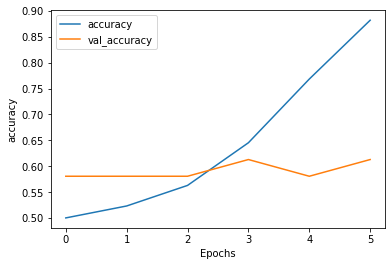

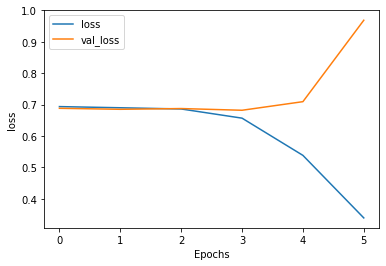

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [35]:
import os
import tempfile

# MODEL_DIR = tempfile.gettempdir()

# version = 1

# export_path = "EXT_MODEL_v"+str(version)

# if os.path.isdir(export_path):
#     print('\nAlready saved a model, cleaning up\n')
#     !rm -r {export_path}

model_opn.save('opn_model.h5')

# print('\nexport_path = {}'.format(export_path))
# !ls -l {export_path}

In [36]:
!gsutil cp agr_model.h5 gs://b21-cap0116
!gsutil cp con_model.h5 gs://b21-cap0116
!gsutil cp ext_model.h5 gs://b21-cap0116
!gsutil cp neu_model.h5 gs://b21-cap0116
!gsutil cp opn_model.h5 gs://b21-cap0116

Copying file://agr_model.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][  1.3 GiB/  1.3 GiB]  144.2 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      
Copying file://con_model.h5 [Content-Type=application/octet-stream]...
==> NOTE: